# Seq2Seq - Char Classification
Using TensorFlow

### TODO:
```
Use words with gaplines to generate more data.
Use wordlist to create sequences using corresponding letters
Try using only words with gaplines - word continuity???
Update normalization
Try using attention with gapclasification :D
Predict same size array or shorter...
Shift classes by 1 -> space for padding
```

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow as tf
import cv2
import random

%matplotlib notebook
# Increase size of plots
plt.rcParams['figure.figsize'] = (9.0, 5.0)


# Helpers
from ocr.datahelpers import loadCharsData, correspondingShuffle, char2idx, idx2char
from ocr.helpers import implt
from ocr.mlhelpers import TrainingPlot, DataSet
from ocr.imgtransform import coordinates_remap
from ocr.tfhelpers import Graph, create_cell

tf.reset_default_graph()
sess = tf.InteractiveSession()

print("OpenCV: " + cv2.__version__)
print("Numpy: " + np.__version__)
print("TensorFlow: " + tf.__version__)

OpenCV: 3.1.0
Numpy: 1.13.1
TensorFlow: 1.3.0


### Global Variables

In [2]:
LANG = 'cz'

PAD = 0                            # Value for PADding images
EOS = 1                            # Value for End Of Sequence (not in use)

N_INPUT = 4096                     # Size of sequence input vector will depend on CNN
num_buckets = 10
CLAS = 83 if LANG =='cz' else 53   # Number of different outputs           

rnn_layers = 4
rnn_residual_layers = 2            # HAVE TO be smaller than encoder_layers
rnn_units = 256

learning_rate = 3e-4               # 1e-4
dropout = 0.5                      # Percentage of dopped out data
train_set = 0.8                    # Percentage of training data

TRAIN_STEPS = 500000                 # Number of training steps!
TEST_ITER = 150
LOSS_ITER = 50
SAVE_ITER = 2000
BATCH_SIZE = 64
EPOCH = 2000

save_loc = 'models/char-clas/' + LANG + '/Bi-RNN/model'

## Load Images and Lables

In [3]:
images, labels = loadCharsData(
    charloc='data/charclas/',
    wordloc='data/words/',
    lang=LANG,
    useWords=True)
# images = len(words) array ... words

# Load Words
tmpWords = []
with open('data/cs_50k.txt') as f:
    for line in f:
        tmpWords.append(line.split(" ")[0])

words = np.empty(2*len(tmpWords), dtype=object)
for i, word in enumerate(tmpWords):
    words[i] = [char2idx(c) for c in list(word)]
    words[i + len(tmpWords)] = [char2idx(c) for c in list(word.title())]
del tmpWords

print("Number of words:", len(words))

Loading chars...
Loading words...
-> Number of words: 1008
Loaded chars from words: 4346
-> Number of chars: 6959
Number of words: 100000


In [4]:
# Create images sequences corresponding to the words
class charFeed:
    def __init__(self, clas, letters):
        self.cnt = np.zeros(clas, dtype=np.int32)
        self.letters = letters
        
    def getChar(self, i):
        if not self.cnt[i] < len(self.letters[i]):
            random.shuffle(self.letters[i])
            self.cnt[i] = 0
            
        self.cnt[i] += 1
        return self.letters[i][self.cnt[i] - 1]
        
letters = np.empty(CLAS, dtype=object)
for i in range(CLAS):
    letters[i] = []
for i in range(len(images)):
    letters[labels[i]].append(images[i])

feeder = charFeed(CLAS, letters)
sequences = np.empty(len(words), dtype=object)
for i, word in enumerate(words):
    sequences[i] = [feeder.getChar(c) for c in word]

# print("Letter count:", [idx2char(i) + ":" + str(len(l)) for i, l in enumerate(letters)])

In [5]:
sequences, words = correspondingShuffle(sequences, words)
# Splitting into train and test data
div = int(train_set * len(sequences))

trainData = sequences[0:div]
testData = sequences[div:]

trainLabels = words[0:div]
testLabels = words[div:]

print("Training images: %g" % div)

Training images: 80000


## Dataset

In [6]:
class BucketDataIterator():
    """ Iterator for feeding seq2seq model during training """
    def __init__(self,
                 images_seq,
                 targets_seq,
                 num_buckets=5,
                 train=True):
        
        self.train = train
        length = [len(seq) for seq in images_seq]                

        # Create pandas dataFrame and sort it by images seq lenght (length)
        # in_length == out_length
        self.dataFrame = pd.DataFrame({'length': length,
                                       'images': images_seq,
                                       'targets': targets_seq
                                      }).sort_values('length').reset_index(drop=True)

        bsize = int(len(images) / num_buckets)
        self.num_buckets = num_buckets
        
        # Create buckets by slicing parts by indexes
        self.buckets = []
        for bucket in range(num_buckets-1):
            self.buckets.append(self.dataFrame.iloc[bucket * bsize: (bucket+1) * bsize])
        self.buckets.append(self.dataFrame.iloc[(num_buckets-1) * bsize:])        
        
        self.buckets_size = [len(bucket) for bucket in self.buckets]

        # cursor[i] will be the cursor for the ith bucket
        self.cursor = np.array([0] * num_buckets)
        self.bucket_order = np.random.permutation(num_buckets)
        self.bucket_cursor = 0
        self.shuffle()
        print("Iterator created.")


    def shuffle(self, idx=None):
        """ Shuffle idx bucket or each bucket separately """
        for i in [idx] if idx is not None else range(self.num_buckets):
            self.buckets[i] = self.buckets[i].sample(frac=1).reset_index(drop=True)
            self.cursor[i] = 0


    def next_batch(self, batch_size):
        """
        Creates next training batch of size: batch_size
        Retruns: image seq, letter seq,
                 image seq lengths, letter seq lengths
        """
        i_bucket = self.bucket_order[self.bucket_cursor]
        # Increment cursor and shuffle in case of new round
        self.bucket_cursor = (self.bucket_cursor + 1) % self.num_buckets
        if self.bucket_cursor == 0:
            self.bucket_order = np.random.permutation(self.num_buckets)
            
        if self.cursor[i_bucket] + batch_size > self.buckets_size[i_bucket]:
            self.shuffle(i_bucket)

        # Handle too big batch sizes
        if (batch_size > self.buckets_size[i_bucket]):
            batch_size = self.buckets_size[i_bucket]

        res = self.buckets[i_bucket].iloc[self.cursor[i_bucket]:
                                          self.cursor[i_bucket]+batch_size]
        self.cursor[i_bucket] += batch_size

        # PAD input sequence and output
        # Pad sequences with <PAD> to same length
        max_length = max(res['length'])
        
        input_seq = np.zeros((batch_size, max_length, N_INPUT), dtype=np.float32)
        for i, img in enumerate(res['images']):
            input_seq[i][:res['length'].values[i]] = img
        
        # Need to pad according to the maximum length output sequence
        targets = np.ones([batch_size, max_length], dtype=np.float32) * PAD
        for i, target in enumerate(targets):
            target[:res['length'].values[i]] = res['targets'].values[i]
        
        return input_seq, targets, res['length'].values


    def next_feed(self, size):
        """ Create feed directly for model training """
        (inputs_,
         targets_,
         length_) = self.next_batch(size)
        return {
            inputs: inputs_,            
            targets: targets_,
            length: length_,
            keep_prob: (1.0 - dropout) if self.train else 1.0
        }

In [7]:
# Create iterator for feeding
train_iterator = BucketDataIterator(trainData,
                                    trainLabels,
                                    num_buckets,
                                    train=True)
test_iterator = BucketDataIterator(testData,
                                   testLabels,
                                   5,
                                   train=False)

Iterator created.
Iterator created.


# Classifier

## Inputs

In [8]:
# Input placehodlers
# N_INPUT -> size of vector representing one image in sequence
# Inputs shape (max_seq_length, batch_size, vec_size) - time major
inputs = tf.placeholder(shape=(None, None, N_INPUT),
                                dtype=tf.float32,
                                name='inputs')
length = tf.placeholder(shape=(None,),
                        dtype=tf.int32,
                        name='length')
# required for training, not required for testing and application
targets = tf.placeholder(shape=(None, None),
                         dtype=tf.int64,
                         name='targets')
# Dropout value
keep_prob = tf.placeholder(tf.float32, name='keep_prob')

## CNN

In [9]:
inpts = inputs

## Bi-RNN

In [10]:
# Cells
cell_fw = create_cell(rnn_units,
                      rnn_layers,
                      rnn_residual_layers,
                      is_dropout=True,
                      keep_prob=keep_prob)
cell_bw = create_cell(rnn_units,
                      rnn_layers,
                      rnn_residual_layers,
                      is_dropout=True,
                      keep_prob=keep_prob)

In [11]:
# Bidirectional RNN
bi_outputs, _ = tf.nn.bidirectional_dynamic_rnn(
    cell_fw = cell_fw,
    cell_bw = cell_bw,
    inputs = inpts,
    sequence_length = length,
    dtype = tf.float32)

outputs = tf.concat(bi_outputs, -1, name='outputs')

# pred = tf.matmul(outputs, W)
# pred = tf.scan(lambda a, x: tf.matmul(x, W), outputs, infer_shape=False)
pred = tf.layers.dense(inputs=outputs,
                       units=CLAS,
                       name='pred')
prediction = tf.argmax(pred, axis=-1, name='prediction')

## Optimizer

In [12]:
# Define loss and optimizer
loss = tf.reduce_mean(tf.losses.sparse_softmax_cross_entropy(logits=pred, labels=targets),
                      name='loss')
train_step = tf.train.AdamOptimizer(learning_rate=learning_rate).minimize(loss,name='train_step')

# Evaluate model
correct_pred = tf.equal(prediction, targets)
accuracy = tf.reduce_mean(tf.cast(correct_pred, tf.float32))

## Training

<IPython.core.display.Javascript object>


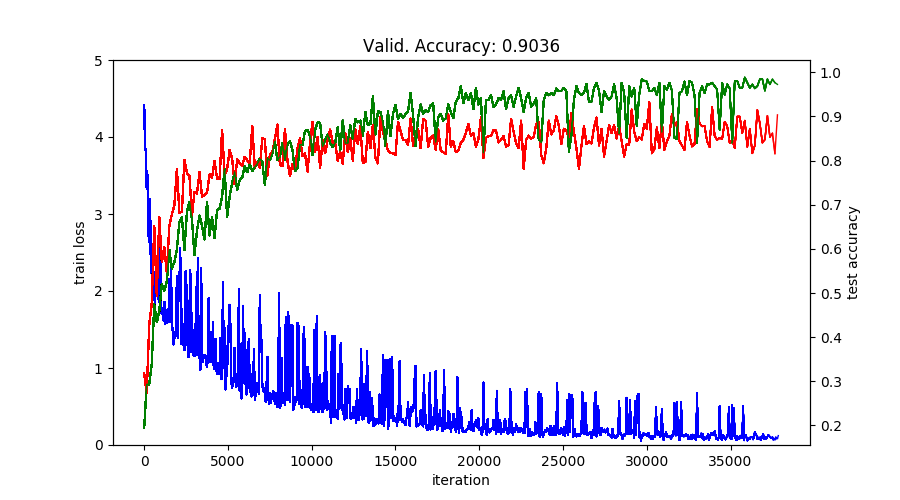

batch 0 - loss: 4.4090438
    expected  > [22 70 44 40 59]
    predicted > [40 62 62 47 80]

batch 2000 - loss: 1.7314653
    expected  > [13 41 29  0]
    predicted > [13 41 29  0]

batch 4000 - loss: 1.8980281
    expected  > [40 59 42 41 39 41 29 40 59  0  0  0  0]
    predicted > [40 59 42 41 40 41 29 40 60  0  0  0  0]

batch 6000 - loss: 1.7465371
    expected  > [44 27 30 41 45 46 40 70  0  0  0  0  0]
    predicted > [48 27 30 31 45 46 35 70  0  0  0  0  0]

batch 8000 - loss: 0.83533561
    expected  > [48 31 40  0]
    predicted > [48 41 40  0]

batch 10000 - loss: 0.7917946
    expected  > [ 5 44 35 40]
    predicted > [ 5 44 35 40]

batch 12000 - loss: 0.93636203
    expected  > [52 59 39 35 40 37 47  0  0  0  0]
    predicted > [52 59 39 35 40 37 47  0  0  0  0]

batch 14000 - loss: 0.69047856
    expected  > [31 50 35 38]
    predicted > [29 50 35 34]

batch 16000 - loss: 0.69069785
    expected  > [47 46 44 59 29 61]
    predicted > [47 46 48 59 29 61]

batch 18000 - los

'models/char-clas/cz/Bi-RNN/model'

In [13]:
sess.run(tf.global_variables_initializer())
saver = tf.train.Saver()

# Creat plot for live stats ploting
trainPlot = TrainingPlot(TRAIN_STEPS, TEST_ITER, LOSS_ITER)

try:
    for i_batch in range(TRAIN_STEPS):
        fd = train_iterator.next_feed(BATCH_SIZE)
        train_step.run(fd)
        
        if i_batch % LOSS_ITER == 0:
            # Plotting loss
            tmpLoss = loss.eval(fd)
            trainPlot.updateCost(tmpLoss, i_batch // LOSS_ITER)
    
        if i_batch % TEST_ITER == 0:
            # Plotting accuracy
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            accTest = accuracy.eval(fd_test)
            accTrain = accuracy.eval(fd)
            trainPlot.updateAcc(accTest, accTrain, i_batch // TEST_ITER)

        if i_batch % SAVE_ITER == 0:
            saver.save(sess, save_loc)
        
        if i_batch % EPOCH == 0:
            fd_test = test_iterator.next_feed(BATCH_SIZE)
            print('batch %r - loss: %r' % (i_batch, sess.run(loss, fd_test)))
            predict_, target_ = sess.run([prediction, targets], fd_test)
            for i, (inp, pred) in enumerate(zip(target_, predict_)):
                print('    expected  > {}'.format(inp))
                print('    predicted > {}'.format(pred))
                break
            print()

except KeyboardInterrupt:
    saver.save(sess, save_loc)
    print('Training interrupted, model saved.')


fd_test = test_iterator.next_feed(2*BATCH_SIZE)
accTest = accuracy.eval(fd_test)
print("Training finished with accuracy:", accTest)
saver.save(sess, save_loc)